# Operation Analytics Project
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

    * Customers who left within the last month – the column is called Churn
    * Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
    * Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
    * Demographic info about customers – gender, age range, and if they have partners and dependents

Main task: Create a machine learning model to predict customers who will churn. Analyze important feature that lead to this behaviour.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape

(7043, 21)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Most of the features are of object data type, only some are of numerical data type.

In [28]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [29]:
#changing the Churn value to binary: 1:churn, 0:no churn
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

#dropping the customer ID because its not usefule for our analysis
# df.drop(['customerID'], axis=1, inplace=True)

#Totalcharges is a string, so we need to convert it to float also there is values like '' which we need to drop
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)

#Senior citizen column should be object type
df['SeniorCitizen'] = df['SeniorCitizen'].astype(str)

In [30]:
#Split the data into train and test with 80:20 split
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2,stratify=df['Churn'])
train.shape, test.shape

((5634, 21), (1409, 21))

In [37]:
get_object_vars = [i for i in train.columns if train[i].dtype == 'object'and i!="customerID"] #getting the object columns
get_int_vars = [i for i in train.columns if train[i].dtype != 'object' and i!="customerID"] #getting the numerical columns

# EDA

Check for missing values

In [38]:
train.isna().sum(), test.isna().sum()

(customerID          0
 gender              0
 SeniorCitizen       0
 Partner             0
 Dependents          0
 tenure              0
 PhoneService        0
 MultipleLines       0
 InternetService     0
 OnlineSecurity      0
 OnlineBackup        0
 DeviceProtection    0
 TechSupport         0
 StreamingTV         0
 StreamingMovies     0
 Contract            0
 PaperlessBilling    0
 PaymentMethod       0
 MonthlyCharges      0
 TotalCharges        9
 Churn               0
 dtype: int64,
 customerID          0
 gender              0
 SeniorCitizen       0
 Partner             0
 Dependents          0
 tenure              0
 PhoneService        0
 MultipleLines       0
 InternetService     0
 OnlineSecurity      0
 OnlineBackup        0
 DeviceProtection    0
 TechSupport         0
 StreamingTV         0
 StreamingMovies     0
 Contract            0
 PaperlessBilling    0
 PaymentMethod       0
 MonthlyCharges      0
 TotalCharges        2
 Churn               0
 dtype: int64)

TotalCharges column has missing values. We will analyse this further when analysing the continuous columns

## Categorical column

Analysing the churn column

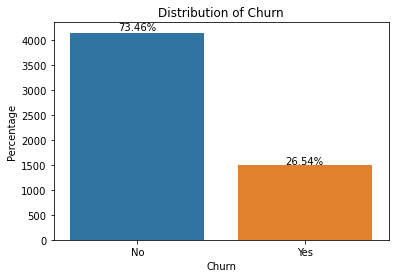

In [39]:
#create a bar graph to see the distribution of the y_train with percentage
ax = sns.countplot(train.Churn.values, label='Percentage')
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.xticks(rotation=0,labels=['No','Yes'],ticks=[0,1])

#display percentage above bar chart
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height*100/train.Churn.shape[0]:.2f}%', (x + width/2, y + height*1.01), ha='center')
plt.show()

This is a highly imbalanced dataset with 26% of the customers churning.

In [40]:
def show_categorical_distribution(column, labels = []):
    """
    This function is used to show the distribution of categorical variables with
    percentage of each category
    """
    plt.figure(figsize=(10,5))
    ax = sns.countplot(x=column, data=train)
    plt.title(column)
    #display percentage above bar chart
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height*100/train.shape[0]:.2f}%', (x + width/2, y + height*1.01), ha='center')
    if labels:
        ax.set_xticklabels(labels)
    plt.show()

### Feature Selection for categorical data

We will check whether if all the categorical columns are infleuncing the Churn column using Chi-square test. We will remove those features that have a p-value less than 0.05.

In [41]:
def get_significant_categorical(
    data = train,
    target = 'Churn',
    columns = get_object_vars,
    threshold = 0.05,
    ):
    """
    This function returns all the categorical columns which have significant difference with target column unique values using
    Chi-squared test and also those columns which are not significant
    """
    significant = np.array([])
    non_significant = np.array([])
    for col in columns:
        chi2, p, dof, expected = chi2_contingency(pd.crosstab(data[col], data[target]))
        if p < threshold:
            significant = np.append(significant, col)
        else:
            non_significant = np.append(non_significant, col)

    return significant, non_significant

In [42]:
significant, non_significant = get_significant_categorical(train, 'Churn', get_object_vars)

print('Significant columns:', *significant)

print('Non-significant columns:', *non_significant)

Significant columns: SeniorCitizen Partner Dependents MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies Contract PaperlessBilling PaymentMethod
Non-significant columns: gender PhoneService


In [43]:
pd.crosstab( train['PhoneService'],train['Churn'])

Churn,0,1
PhoneService,,
No,422,134
Yes,3717,1361


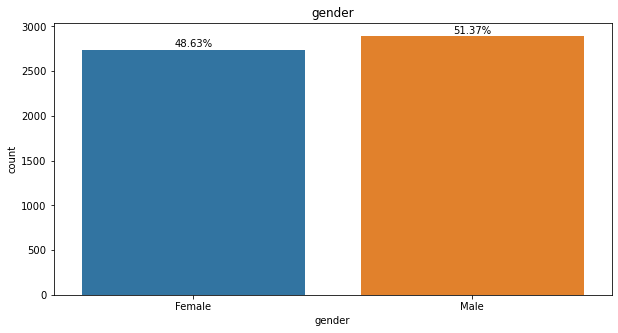

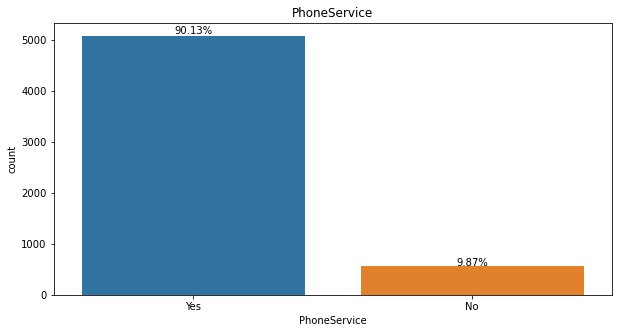

In [44]:
for col in non_significant:
    show_categorical_distribution(col)

'gender' & 'PhoneService' is not having significant difference between the churn unique values using Chi-squared test of indepedence. Hence we will remove these features 

In [45]:
train.drop(non_significant, axis=1, inplace=True)
test.drop(non_significant, axis=1, inplace=True)

## Continuous data

In [46]:
train[get_int_vars].head(5)

,tenure,MonthlyCharges,TotalCharges,Churn
3234,24,19.70,452.55,0
4076,70,99.35,6944.50,0
5068,71,20.90,1493.20,0
617,66,102.85,6976.75,0
5314,70,64.55,4504.90,0


There are missing values in the TotalCharges column. We will analyse this.

In [47]:
train.sample(5)

,customerID,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6768,9739-JLPQJ,0,Yes,Yes,72,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),117.50,8670.10,0
4902,5092-STPKP,0,No,No,24,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Credit card (automatic),56.35,1381.20,0
5579,2225-ZRGSG,0,Yes,Yes,70,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,No,Bank transfer (automatic),93.90,6579.05,1
4476,7434-SHXLS,0,No,No,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.90,20.90,1
1550,9957-YODKZ,1,Yes,No,6,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,80.80,457.10,0


Total Charges is close to MonthlyCharges * tenure

<AxesSubplot:>

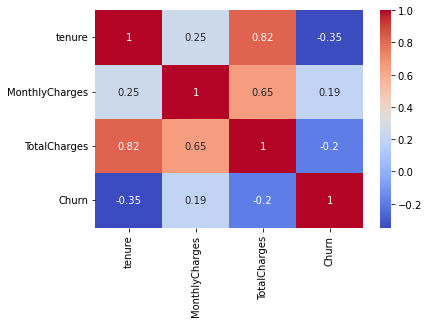

In [48]:
sns.heatmap(
train.corr(),
annot=True,
cmap='coolwarm',
)

Looking at the correlation matrix there is a strong correlation between tenure, MonthlyCharges with TotalCharges. Hence we will drop TotalCharges column. Also, Every column has a weak correlation with the churn column. We will investigate further during model building process and remove if these features have not a significant impact on the churn.

In [49]:
train.drop(['TotalCharges'], axis=1, inplace=True)
test.drop(['TotalCharges'], axis=1, inplace=True)

get_int_vars.remove('TotalCharges')

We will check for outliers using the boxplot.

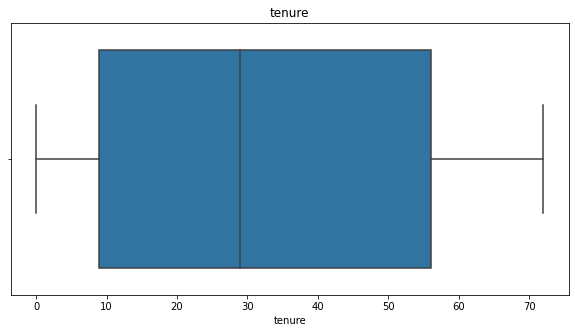

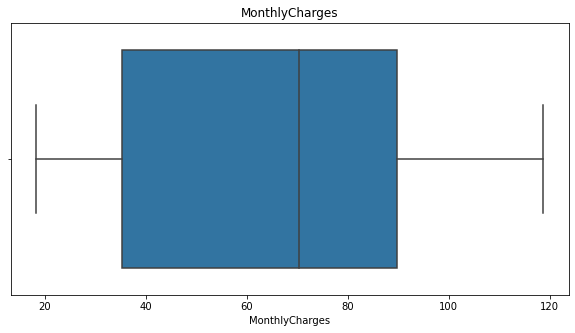

In [50]:
#Outlier detection using boxplot
cols = set(get_int_vars)
cols.discard('Churn')
for col in cols:
    plt.figure(figsize=(10,5))
    plt.title(col)
    sns.boxplot(x=col, data=train)
    plt.show()

No outliers are found on the numerical columns

In [51]:
def show_numerical_distribution(column, bins = 10, data = train):
    """
    This function is used to show the distribution of numerical variables with
    bins
    """
    plt.figure(figsize=(10,5))
    ax = sns.distplot(data[column], bins=bins)
    plt.title(column)
    plt.show()

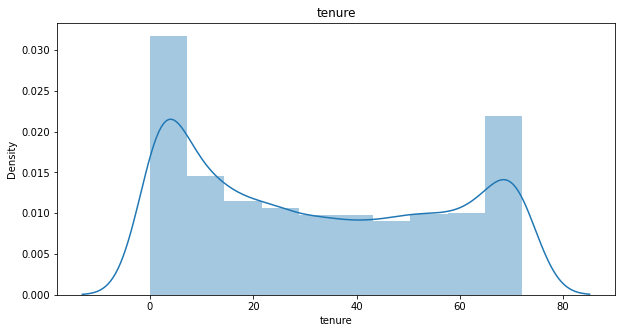

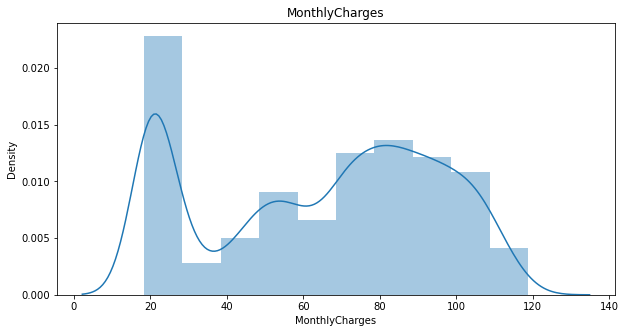

In [52]:
for col in cols:
    show_numerical_distribution(col)

In [53]:
#save the train and test data to csv files
train.to_csv('../data/train.csv', index=False)
test.to_csv('../data/test.csv', index=False)

# Future Work

    * The data has a lot of categorical features. We will try using response encoding to convert categorical features into numerical features. (One hot encoding will not suitable for this dataset because of the no. of features will increase)
    * We will try using feature selection to remove the features that have no impact on the churn column using tree based models.
    * Create a model to predict the churn column using Decision Tree, Random Forest, Logistic Regression, XGBoost and LigthGBM.